### Types of gym_bandits
`BanditTwoArmedDeterministicFixed-v0`: Simplest case where one bandit always pays, and the other always doesn't

`BanditTwoArmedHighLowFixed-v0`: Stochastic version with a large difference between which bandit pays out of two choices

`BanditTwoArmedHighHighFixed-v0`: Stochastic version with a small difference between which bandit pays where both are good

`BanditTwoArmedLowLowFixed-v0`: Stochastic version with a small difference between which bandit pays where both are bad

`BanditTenArmedRandomFixed-v0`: 10 armed bandit with random probabilities assigned to payouts

`BanditTenArmedRandomRandom-v0`: 10 armed bandit with random probabilities assigned to both payouts and rewards

`BanditTenArmedUniformDistributedReward-v0`: 10 armed bandit with that always pays out with a reward selected from a uniform distribution

`BanditTenArmedGaussian-v0`: 10 armed bandit mentioned on page 30 of Reinforcement Learning: An Introduction (Sutton and Barto)

----------

#### References
- gym_bandits library from https://github.com/JKCooper2/gym-bandits
- moving average function https://github.com/klangner/rl-examples/blob/master/notebooks/openai-gym/%5Bnot%20solved%5D%20CartPole.ipynb

In [198]:
import gym_bandits
import gym
import matplotlib.pyplot as plt
import numpy as np

In [199]:
env = gym.make("BanditTenArmedGaussian-v0")
env.reset()

[2018-01-22 15:50:52,416] Making new env: BanditTenArmedGaussian-v0


0

In [206]:
# helper functions

def moving_average(xs, n=100):
    ret = np.cumsum(xs, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def divide_by_index(x): 
    output = [0] * len(x)
    for n in range(len(x)):
        output[n] = float(x[n]) / (n + 1)
    return output

def avg_across_arrays(xs): # where xs is an array of arrays, all of same length
    length = len(xs[0])
    num_arrays = len(xs)
    output = [0] * length
    for j in range(length):
        xsum = 0.
        for i in range(num_arrays):
            xsum += xs[i][j]
        output[j] = xsum / num_arrays
    return output

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

In [243]:
# defining the agents

class SimpleAgent(object):
    def __init__(self, num_actions, Q_init=0):
        self.num_actions = num_actions
        self.A = range(num_actions)
        self.N = [0] * num_actions # the number of times N(a) has been called
        self.Q = [Q_init] * num_actions # the expected value of choosing Q(a)
    
    def choose_action(self, epsilon): # choose random action with probability epsilon        
        rand = np.random.rand()
        if (rand < epsilon):
            choice = np.random.choice(self.A)
            return choice
        else:
            choice = np.argmax(self.Q)
            return choice
    
    def learn(self, action, reward): # update Q and N
        self.N[a] += 1
        self.Q[a] += (1 / self.N[a]) * (reward - self.Q[a])
    
    def alpha_learn(self, action, reward, alpha=0.1): # update Q and N
        self.N[a] += 1
        self.Q[a] += alpha * (reward - self.Q[a])

        
class GradientAgent(SimpleAgent):
    def __init__(self, num_actions, Q_init=0):
        SimpleAgent.__init__(self, num_actions, Q_init=0)
        self.H = [1. / num_actions] * num_actions
        self.avg_reward = 0
        self.timestep = 0
    
    def choose_action(self): # choose random action with probability epsilon        
        return np.random.choice(num_actions, p=self.H)
    
    def learn(self, action, reward, alpha=0.4):
        self.timestep += 1
        self.avg_reward = (self.avg_reward + reward) / self.timestep
        for a in self.A:
            if a == action:
                self.H[a] = self.H[a] + alpha * (reward - self.avg_reward) * (1 - softmax(self.H)[a])
            else:
                self.H[a] = self.H[a] + alpha * (reward - self.avg_reward) * (softmax(self.H)[a])
    

In [244]:
# get reward distribution

r_dist = list(map(lambda x: x[0], env.env.r_dist))
    
optimal_choice = np.argmax(r_dist)
print("optimal choice is action at index:", optimal_choice)
print("reward distribution:", r_dist)


optimal choice is action at index: 1
reward distribution: [-0.12598566557353535, 0.8386791735948018, -2.1657575992308558, -0.6494371950402243, -0.012471506553752247, -0.0430443715809945, -0.8043606413447715, 0.42617345169619597, 0.13730919470443126, -0.40954334533078207]


In [245]:
# event loop for i episodes each with t timesteps

timesteps = 1000
episodes = 100

agent = GradientAgent(env.action_space.n)
e = -1. # epsilon factor for exploration (negative value will never be selected)

all_optimal_trackers = []
all_total_rewards = []
all_rewards = []

for i in range(episodes):
    
    optimal_picks = 0
    optimal_tracker = []
    
    total_reward = 0
    total_rewards = []
    rewards = []
    
    for t in range(timesteps):
        a = agent.choose_action()

        if a == optimal_choice: optimal_picks += 1
        optimal_tracker.append(optimal_picks)

        observation, reward, done, info = env.step(a)

        total_reward += reward
        rewards.append(reward)
        total_rewards.append(total_reward)
        agent.learn(a, reward)
    
    all_optimal_trackers.append(divide_by_index(optimal_tracker))
    all_total_rewards.append(divide_by_index(total_rewards))
    all_rewards.append(moving_average(rewards))


NameError: name 'num_actions' is not defined

In [237]:
# get averages across all episodes

avg_rewards = avg_across_arrays(all_rewards)
avg_total_rewards = avg_across_arrays(all_total_rewards)
avg_optimal = avg_across_arrays(all_optimal_trackers)

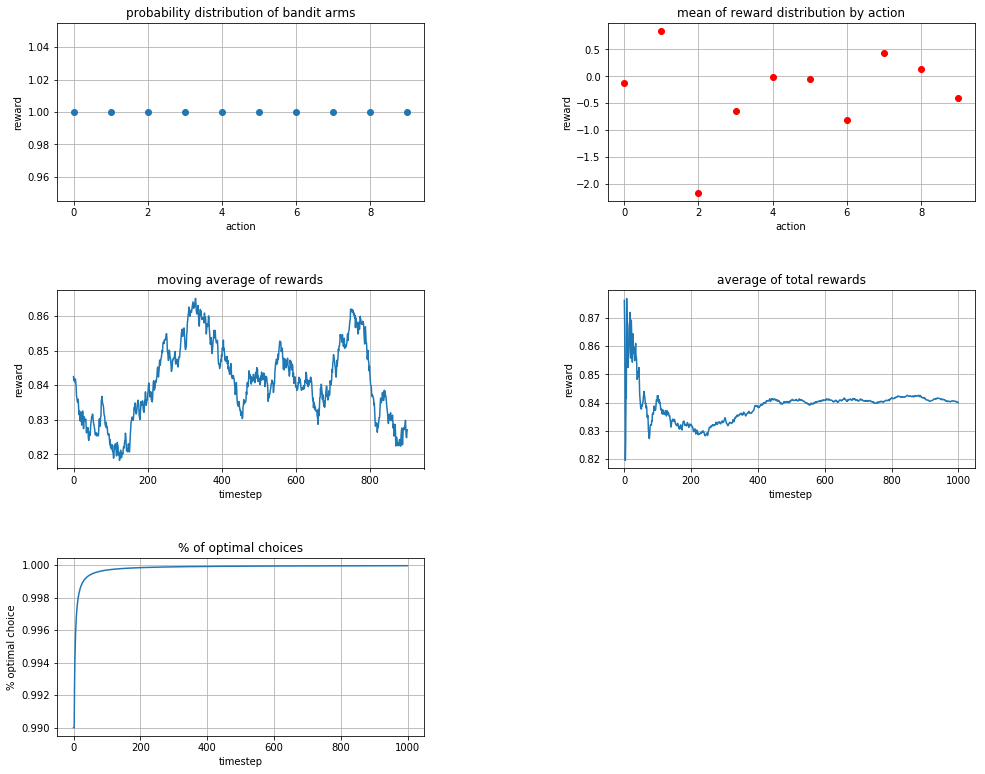

In [242]:
# plotting

plt.figure(1, figsize=(15,10))

# probability distribution
plt.subplot(321)
plt.plot(env.env.p_dist, 'o')
plt.title('probability distribution of bandit arms')
plt.xlabel('action')
plt.ylabel('reward')
plt.grid(True)


# reward distribution
plt.subplot(322)
plt.plot(r_dist, 'ro')
plt.title('mean of reward distribution by action')
plt.xlabel('action')
plt.ylabel('reward')
plt.grid(True)


# moving average of rewards
plt.subplot(323)
plt.plot(avg_rewards)
plt.title('moving average of rewards')
plt.xlabel('timestep')
plt.ylabel('reward')
plt.grid(True)

# moving average of total rewards
plt.subplot(324)
plt.plot(avg_total_rewards) # to get average reward
plt.title('average of total rewards')
plt.xlabel('timestep')
plt.ylabel('reward')
plt.grid(True)

# % of optimal choices
plt.subplot(325)
plt.plot(avg_optimal) # to get % times optimal choice was chosen
plt.title('% of optimal choices')
plt.xlabel('timestep')
plt.ylabel('% optimal choice')
plt.grid(True)

plt.subplots_adjust(top=0.99, bottom=.0, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.5)

plt.show()